In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
#change into Celcius
ds['analysed_sst'] = ds.analysed_sst - 273.15

In [3]:
#Get the selected data as a reference 2002-2012 data, calculate mean and SD
test = ds.sel(time=slice('2002-06-01', '2012-12-31'))
test_mean = test.analysed_sst.groupby('time.month').mean()
test_sd = test.analysis_error.groupby('time.month').mean()

In [4]:
#segmenting the dataset based on year
ds_2014 = ds.sel(time=slice('2014-01-01', '2014-12-31'))
ds_2015 = ds.sel(time=slice('2015-01-01', '2015-12-31'))
ds_2016 = ds.sel(time=slice('2016-01-01', '2016-12-31'))

In [5]:
#calculate the means for each month for each selected year
ds_2014m = ds_2014.analysed_sst.groupby('time.month').mean()
ds_2015m = ds_2015.analysed_sst.groupby('time.month').mean()
ds_2016m = ds_2016.analysed_sst.groupby('time.month').mean()

In [6]:
#calcualte the difference between monthly average and mean for each year 2014-2016
diff_2014 = ds_2014m - test_mean
diff_2015 = ds_2015m - test_mean
diff_2016 = ds_2016m - test_mean

In [7]:
#add a dimension 'year' to the data arrays; used for plotting purposes
diff_2014 = diff_2014.assign_coords(year="year").expand_dims(dim=dict(year= [2014]))
diff_2015 = diff_2015.assign_coords(year="year").expand_dims(dim=dict(year= [2015]))
diff_2016 = diff_2016.assign_coords(year="year").expand_dims(dim=dict(year= [2016]))

In [8]:
#mask the points where the difference is less than 1 SD for the month/coordinate
masked_2014 = diff_2014.where(abs(diff_2014) >= test_sd)
masked_2015 = diff_2015.where(abs(diff_2015) >= test_sd)
masked_2016 = diff_2016.where(abs(diff_2016) >= test_sd)

In [9]:
#combine into one dara array to use for plotting
combined_anomalies = xr.merge([masked_2014, masked_2015, masked_2016])
anomaly = combined_anomalies.analysed_sst

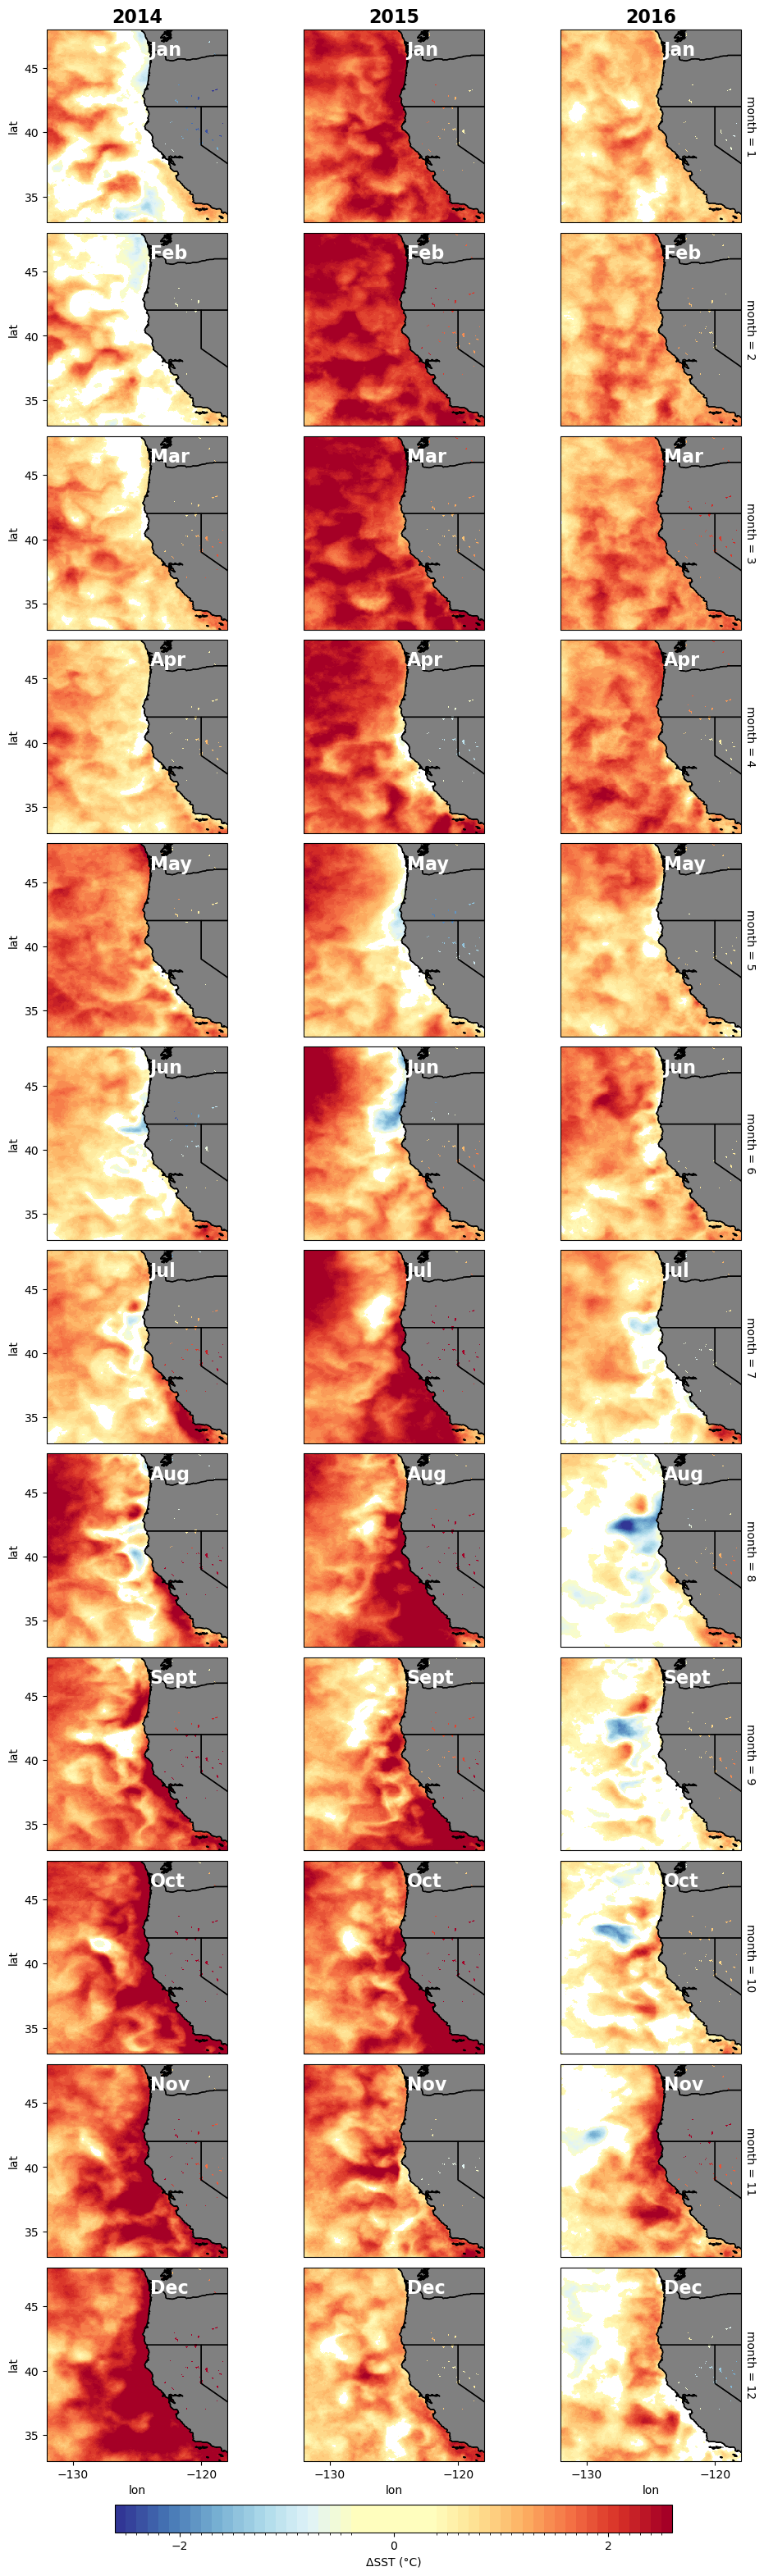

In [17]:
#plot
levels = [round(x, 1) for x in np.arange(-2.5,2.6, 0.1) if abs(x)>0.34]
titles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
year = ['2014', '2015', '2016']
       
z = anomaly.plot(col='year', row = "month", x = 'lon', y = 'lat', col_wrap=3, 
        transform=ccrs.PlateCarree(),
        levels = levels,
        #colors = colors,
        #vmin = -2.5, vmax = 2.5,
        cmap = 'RdBu_r',
        subplot_kws={'projection': ccrs.PlateCarree()},
        cbar_kwargs={'orientation': 'horizontal', 'label' : 'ΔSST (°C)', "ticks":[-2,0,2],
                    'pad':0.015, 'shrink' : 0.7, 'extendrect':True, 'extendfrac' : 0.02, 'spacing':'proportional'})

for i in range(12):
    z.axes[i,0].set_yticks([35,40,45])
    for j in range(3):
        z.axes[11,j].set_xticks([-130,-120])
        z.axes[i,j].set_title("")
        z.axes[0,j].set_title(year[j], fontsize = 16, weight='semibold')
        z.axes[i,j].annotate(titles[i], xy = (-124, 46),fontsize = 16, weight = "semibold", color = 'white')
        

for ax in z.axes.flat:
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines("10m", color="k")
    ax.add_feature(cfeature.LAND, color="grey")
    ax.add_feature(cfeature.STATES.with_scale("10m"))

#plt.savefig('Q4.png')

In [11]:
#TO DO:
#custom colorplot, not a gradient- more discrete